# Pipeline for Phase change materials. Scripting example

Consists of 2 sections:

* crystallinity map generation

* region clustering

In [4]:
%matplotlib nbagg

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

from libertem.udf import UDF
from libertem.masks import _make_circular_mask
from libertem.api import Context
from libertem.udf.sumsigudf import run_sumsig
from libertem.udf.stddev import run_stddev

## Crystallinity map generation

In [5]:
ctx = Context()
ds = ctx.load("blo", path=r"C:\Users\ruzaeva\Desktop\09-19-18 ASTAR Werner\dev25\MS3 12 K P.blo")

Use `libertem.udf.sumsigudf` to calculate the sum over whole detector area or Bright/Dark field image.

Where `sumsig` - sum over detector area

<IPython.core.display.Javascript object>


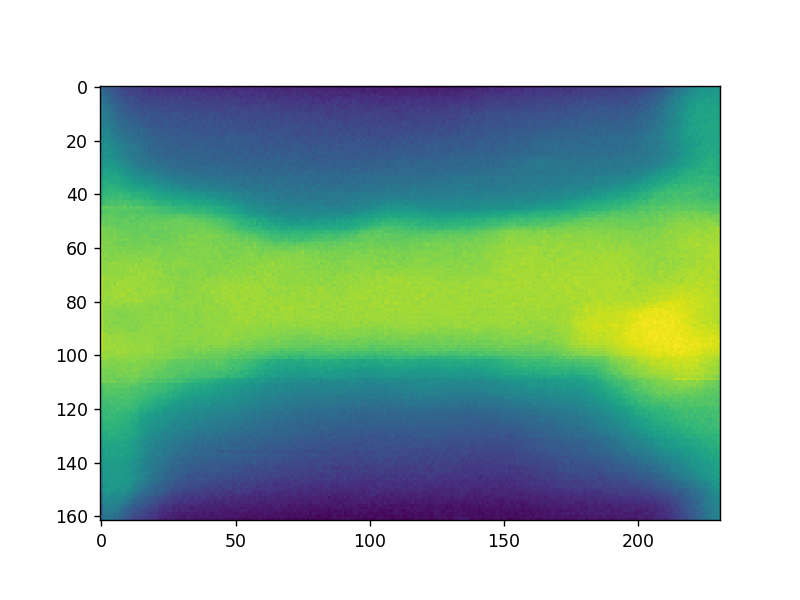

In [7]:
sumsig=run_sumsig(ctx,ds)
sumsig=sumsig["intensity"].data
plt.figure()
plt.imshow(sumsig)

To reduce the amount of data to process, amorphous membrane (substrate) can be masked out.

For that, you can use a simple binary threshold for `sumsig` map.

Where `memmask` is a boolean mask with `True` for specimen regions and `False` for membrane regions

<IPython.core.display.Javascript object>


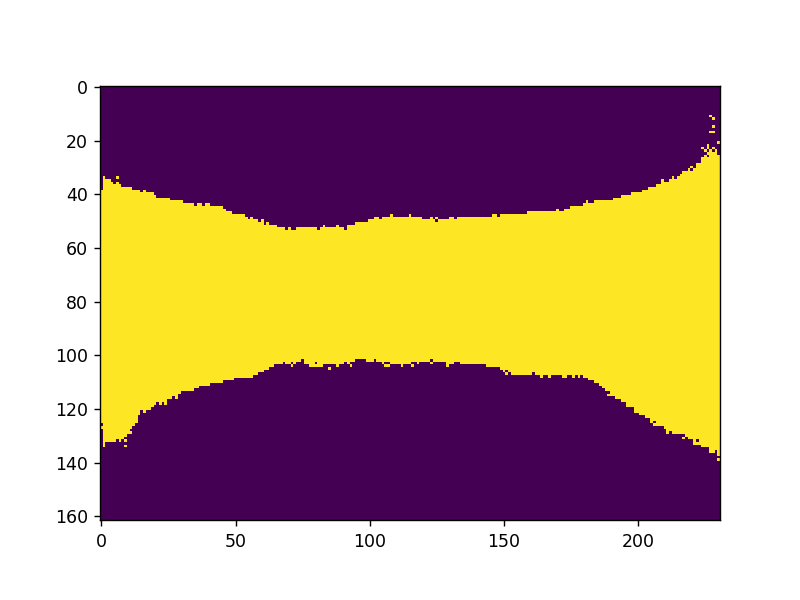

In [9]:
memmask=(sumsig>1.73e+06)
plt.figure()
plt.imshow(memmask)

To highlight crystalline regions of phase change material, use `libertem.udf.crystallinity` function, which is integrating over the ring with `rad_in` and `rad_out` each frame spectrum which belongs to `roi`.

where `crystal` is crystallinity map

<IPython.core.display.Javascript object>


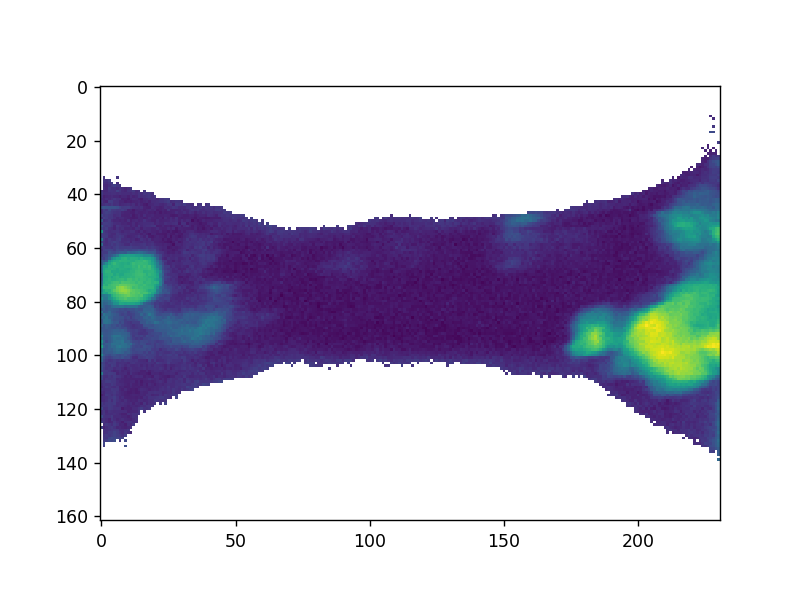

In [13]:
from  libertem.udf.crystallinity import run_analysis_crystall
crystal=run_analysis_crystall(ctx, ds, rad_in=10, rad_out=28,
                              real_center=None, real_rad=None, roi=memmask)
crystal=crystal["intensity"].data
plt.figure()
plt.imshow(crystal)

Since there is no need to do clustering for the amorphous region of the specimen, it can be masked out as well

C:\Users\ruzaeva\AppData\Local\Continuum\anaconda3\envs\LiberTEM\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


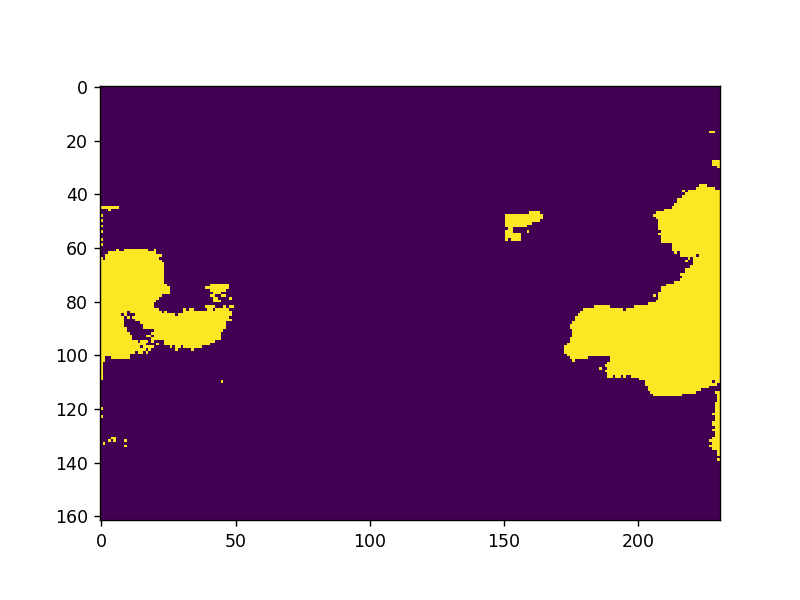

In [39]:
maskcrystal=(crystal>4.8e+05)
plt.figure()
plt.imshow(maskcrystal)

## Crystalline regions clustering#

For feature vector generation use `feature_vector_maker`

where `vector` is flat boolean feature vector, `coords` are coordinates of peaks on standard deviation image over all crystalline frames


In [40]:
from  libertem.udf.feature_vector_maker import make_feature_vec
vector, coords=make_feature_vec(
    ctx, ds, delta=0.07, n_peaks=100, min_dist=2, center=(73,69),
    rad_in=8, rad_out=40, roi=maskcrystal)
crystvec=vector['feature_vec'].raw_data

c:\users\ruzaeva\documents\github\libertem\src\libertem\udf\stddev.py:171: RuntimeWarning: invalid value encountered in sqrt
  pass_results['std'] = np.sqrt(pass_results['var'].data)


To check pixels which will be used for feature vector generation, you can plot peak coordinates (`coords`) on standard deviation image ( `std` ) of crystalline frames (can be calculated with `libertem.udf.stddev` function)

c:\users\ruzaeva\documents\github\libertem\src\libertem\udf\stddev.py:171: RuntimeWarning: invalid value encountered in sqrt
  pass_results['std'] = np.sqrt(pass_results['var'].data)


<IPython.core.display.Javascript object>


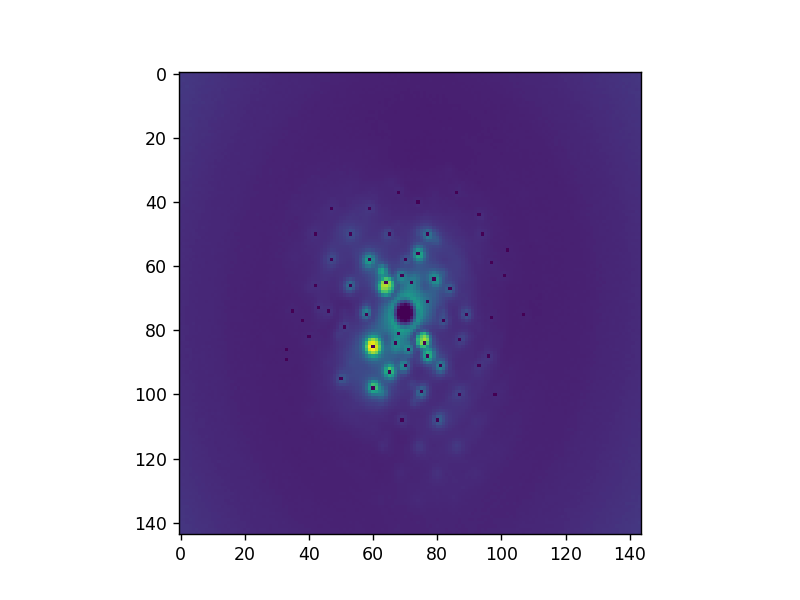

In [41]:
res_stat = run_stddev(ctx, ds, roi=maskcrystal)
std=res_stat['std']
std[coords[:,0],coords[:,1]]=0
plt.figure()
plt.imshow(std)

Clustering can be done with any of clustering algorithm you like with `crystvec` feature vector as an input.
After flat `labels` vector rearangement, you will get 2-D `labelmask` map

Here Hierarchical clustering algorithm with ward merging criterion is shown

In [48]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(affinity='euclidean',
                                     n_clusters=11, linkage='ward').fit(crystvec)
labels = np.array(clustering.labels_+1)
#some shape rearangement
labelmask=np.zeros(maskcrystal.shape)
labelmask[maskcrystal]=labels

To visualize different regions of the specimen can be done with simple addition of `labelmask` and `memmask` 

<IPython.core.display.Javascript object>


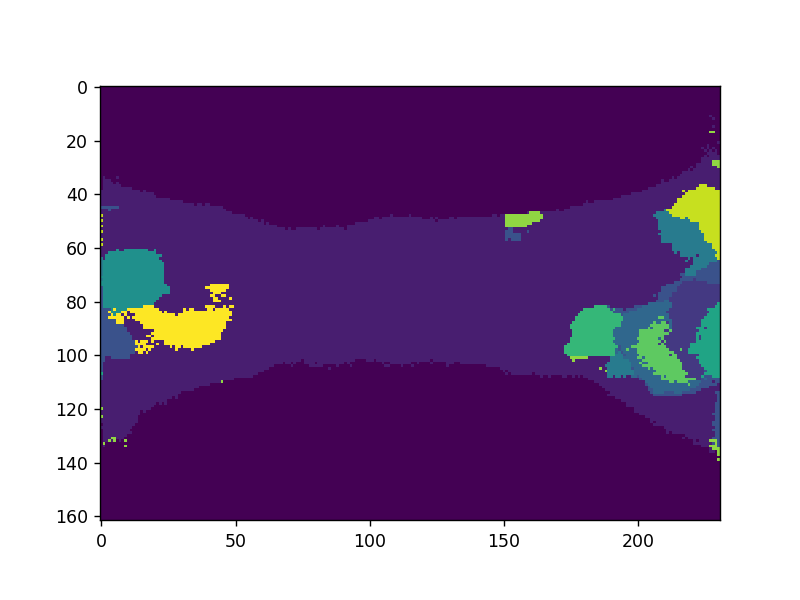

In [51]:
clusters=labelmask+memmask
plt.figure()
plt.imshow(clusters)